# Reinforcement Learning (RL)

Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by taking actions in an environment to maximize some notion of cumulative reward. The main components of an RL setup are:

- **Agent**: The learner or decision-maker (e.g., the car in your racing project).
- **Environment**: The context in which the agent operates (e.g., the race track).
- **State**: A representation of the environment at a given time (e.g., the car's position, speed, and nearby obstacles).
- **Action**: The set of all possible moves the agent can take (e.g., accelerate, brake, turn left/right).
- **Reward**: A feedback signal that tells the agent how well it is performing (e.g., points for completing laps, penalties for crashing).

The agent interacts with the environment by observing the state, taking actions, and receiving rewards, which it uses to learn a policy—a strategy for choosing actions based on states.

# Proximal Policy Optimization (PPO)

Proximal Policy Optimization (PPO) is a popular reinforcement learning algorithm designed to improve the stability and reliability of training policies. It is a policy gradient method, meaning it directly optimizes the policy (the mapping from states to actions) rather than the value function.

###Key Features of PPO:

- **Clipped Objective**: PPO uses a clipped objective function to prevent large policy updates that could destabilize training. This ensures that the new policy does not deviate too far from the old one, allowing for smoother learning.
- **On-Policy Learning**: PPO learns from the current policy by collecting data through interactions with the environment. It updates the policy based on the latest observations and rewards.

# Objective

In this car racing project, the objective is to train an autonomous car to navigate a racing track effectively and efficiently using the PPO algorithm. The focus will be on maximizing cumulative rewards by completing laps quickly while minimizing penalties for collisions and other undesirable behaviors.


# Install  Dependencies


In [1]:
!apt-get install swig
!pip install gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,099 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

# Imports

# Overview of Gym

OpenAI Gym is a toolkit designed for developing and experimenting with reinforcement learning (RL) algorithms. It provides a wide variety of environments that serve as testing grounds for different RL methods. The main goals of Gym are to create a standardized interface for RL environments and to promote research and experimentation in this field.

## Key Components of Gym

- **Environment**: The environment represents the scenario in which an agent operates. Each environment has its own dynamics, states, actions, and rewards. Gym provides a range of pre-built environments, including:
  - Classic control tasks (e.g., CartPole, MountainCar).
  - Atari games (e.g., Pong, Breakout).
  - Robotics simulations (e.g., robotic arms).
  

## Benefits of Using Gym

- **Standardization**: Gym provides a consistent interface across various environments, making it easier to compare different algorithms.
- **Diversity of Tasks**: With a wide array of environments, Gym allows researchers to test their RL algorithms on different types of challenges.


In [2]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import time
from collections import deque
import matplotlib
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

action_repeat = 10
# Create the CarRacing environment with the new step API
env = gym.make('CarRacing-v2', new_step_api=True, verbose=0)

state = env.reset()
print('env.action_space.shape: ', env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print('reward_threshold', reward_threshold)

device:  cuda
env.action_space.shape:  (3,)
reward_threshold 900


# Environment Wrapper and Image Preprocessing

frame.shape:  (96, 96, 3)
img.shape:  (96, 96)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


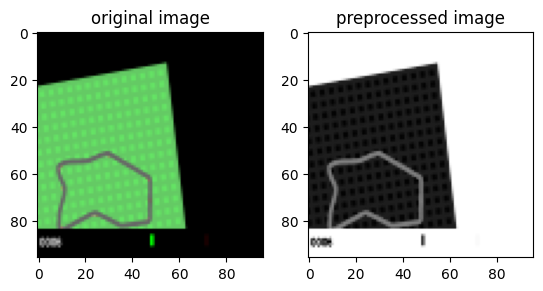

In [3]:
# show what a preprocessed image looks like
frame, _, _, _, _ = env.step(np.array([2., 1., 1.])) # Added an extra "_" to unpack 5 values

print('frame.shape: ', frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')


def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
    gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    if norm:
        # normalize
        gray = gray / 128. - 1.
    return gray

img_gray = rgb2gray(frame)

plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

In [4]:
import numpy as np

class Wrapper():
    """
    Environment wrapper for CarRacing
    """

    def __init__(self, env):
        self.env = env

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()
        self.die = False

        # Get the output from the reset function
        img_rgb = self.env.reset()  # Now we're only expecting one output

        img_gray = rgb2gray(img_rgb)  # Convert RGB to grayscale
        self.stack = [img_gray] * img_stack  # Initialize stack with the gray image
        return np.array(self.stack)  # Return the stacked images

    def step(self, action):
        total_reward = 0
        for i in range(action_repeat):
            results = self.env.step(action)  # Capture all returned values

            # Ensure that results unpacking matches the returned values from the environment
            img_rgb, reward, die, done, info = results  # Unpack correctly

            # Don't penalize "die state"
            if die:
                reward += 100

            # Green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05

            total_reward += reward

            # If no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else done

            if done or die:
                break

        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == img_stack

        return np.array(self.stack), total_reward, done, die , info

    @staticmethod
    def reward_memory():
        # Record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory


#Model

In [5]:
import torch.nn as nn

class Net(nn.Module):
    """
    Convolutional Neural Network for PPO
    """

    def __init__(self, img_stack):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(img_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v

#Agent

In [6]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import numpy as np


img_stack=4

transition = np.dtype([('s', np.float64, (img_stack, 96, 96)),
                       ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (img_stack, 96, 96))])

GAMMA=0.99 # discount, the coefficient related to the next state
EPOCH= 1 # beter than 10
MAX_SIZE = 2000 ## CUDA out of mem for max_size=10000
BATCH=128
EPS=0.1 #  # the clipping parameter using for calculation of the action loss
LEARNING_RATE = 0.001

class Agent():
    """ Agent for training """

    def __init__(self, device):
        self.training_step = 0
        self.net = Net(img_stack).double().to(device)
        self.buffer = np.empty(MAX_SIZE, dtype=transition)
        self.counter = 0
        self.device = device

        self.optimizer = optim.Adam(self.net.parameters(), lr=LEARNING_RATE)  ## lr=1e-3

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(self.device).unsqueeze(0)

        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp


    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == MAX_SIZE:
            self.counter = 0
            return True
        else:
            return False

    def update(self):
        self.training_step += 1

        s = torch.tensor(self.buffer['s'], dtype=torch.double).to(self.device)
        a = torch.tensor(self.buffer['a'], dtype=torch.double).to(self.device)
        r = torch.tensor(self.buffer['r'], dtype=torch.double).to(self.device).view(-1, 1)
        next_s = torch.tensor(self.buffer['s_'], dtype=torch.double).to(self.device)

        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype=torch.double).to(self.device).view(-1, 1)

        with torch.no_grad():
            target_v = r + GAMMA * self.net(next_s)[1]
            adv = target_v - self.net(s)[1]
            # adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        for _ in range(EPOCH):
            for index in BatchSampler(SubsetRandomSampler(range(MAX_SIZE)), BATCH, False):

                alpha, beta = self.net(s[index])[0]
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])

                surr1 = ratio * adv[index]

                # clipped function
                surr2 = torch.clamp(ratio, 1.0 - EPS, 1.0 + EPS) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])
                loss = action_loss + 2. * value_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

#Training

In [7]:
!mkdir dir_chk
def save(agent, directory, filename, suffix):
    torch.save(agent.net.state_dict(), '%s/%s_%s.pth' % (directory, filename, suffix))

In [8]:
import time
from collections import deque
import numpy as np
import torch

env_wrap = Wrapper(env)  # Wrap your environment here

limits = [200, 400, 600, 800, 830, 870, 900]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits) - 1):
        if limits[i] < j < limits[i + 1]:
            suf = str(limits[i + 1])
            break

    if j > limits[-1]:  # If j is greater than the last limit
        suf = str(limits[-1])

    return suf

# Create an instance of the Agent class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = Agent(device)

def ppo_train(n_episodes=1500, save_every=500):
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []

    timestep_after_last_save = 0
    time_start = time.time()

    running_score = 0

    for i_episode in range(n_episodes):
        timestep = 0
        total_reward = 0

        # Reset environment for each episode
        state = env_wrap.reset()

        while True:
            action, a_logp = agent.select_action(state)
            # Removed 'self.' since it's not a class method
            next_state, reward, done, die , info = env_wrap.step(
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.])
            )

            transition = (state, action, a_logp, reward, next_state) # Updated transition to use next_state
            if agent.store(transition):
                print('Updating agent...')
                agent.update()

            total_reward += reward
            state = next_state # Updated state with next_state

            timestep += 1
            timestep_after_last_save += 1

            if done or die:
                break

        running_score = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        elapsed_time = int(time.time() - time_start)
        print('Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score: {:.2f}, \
Time: {:02}:{:02}:{:02}'.format(
            i_episode, timestep, total_reward, avg_score, running_score,
            elapsed_time // 3600, elapsed_time % 3600 // 60, elapsed_time % 60
        ))

        # Save episode if more than save_every timesteps
        if timestep_after_last_save >= save_every:
            timestep_after_last_save %= save_every
            suf = return_suffix(avg_score)
            save(agent, 'dir_chk', 'model_weights', suf)

        if np.mean(scores_deque) > reward_threshold:
            print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !" \
                  .format(running_score, avg_score))
            break

    return scores_array, avg_scores_array

# Call the training function
scores, avg_scores = ppo_train()

Ep. 0, Ep.Timesteps 87, Score: -17.92, Avg.Score: -17.92, Run.Score: -0.18, Time: 00:00:12
Ep. 1, Ep.Timesteps 80, Score: -17.97, Avg.Score: -17.94, Run.Score: -0.36, Time: 00:00:23
Ep. 2, Ep.Timesteps 100, Score: -17.27, Avg.Score: -17.72, Run.Score: -0.53, Time: 00:00:35
Ep. 3, Ep.Timesteps 100, Score: -11.11, Avg.Score: -16.07, Run.Score: -0.63, Time: 00:00:48
Ep. 4, Ep.Timesteps 88, Score: -18.07, Avg.Score: -16.47, Run.Score: -0.81, Time: 00:00:59
Ep. 5, Ep.Timesteps 90, Score: -18.00, Avg.Score: -16.72, Run.Score: -0.98, Time: 00:01:10
Ep. 6, Ep.Timesteps 100, Score: -18.07, Avg.Score: -16.92, Run.Score: -1.15, Time: 00:01:23
Ep. 7, Ep.Timesteps 98, Score: -18.08, Avg.Score: -17.06, Run.Score: -1.32, Time: 00:01:35
Ep. 8, Ep.Timesteps 88, Score: -17.96, Avg.Score: -17.16, Run.Score: -1.48, Time: 00:01:46
Ep. 9, Ep.Timesteps 91, Score: -25.32, Avg.Score: -17.98, Run.Score: -1.72, Time: 00:01:58
Ep. 10, Ep.Timesteps 92, Score: -25.56, Avg.Score: -18.67, Run.Score: -1.96, Time: 00:0

In [9]:
def load(agent, directory, filename):
    agent.net.load_state_dict(torch.load(os.path.join(directory,filename)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Watch the Agent

In [10]:
from collections import deque
import os

def play(env, agent, n_episodes):
    state = env_wrap.reset()

    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        state = env_wrap.reset()
        score = 0

        time_start = time.time()

        while True:

            action, a_logp = agent.select_action(state)
            env.render()

            next_state, reward, done, die, info = env_wrap.step(action)  # Unpack correctly

            state = next_state
            score += reward

            if done or die:
                break

        s = (int)(time.time() - time_start)

        scores_deque.append(score)
        scores.append(score)

        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))

In [11]:
load(agent, 'dir_chk', 'model_weights_0.pth')
play(env, agent, n_episodes=5)

<ipython-input-9-d349c3b0fb74>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.net.load_state_dict(torch.load(os.path.join(directory,filename)))
/usr/local/lib/python

Episode 1	Average Score: 4.36,	Score: 4.36 	Time: 00:00:05
Episode 2	Average Score: -5.68,	Score: -15.71 	Time: 00:00:11
Episode 3	Average Score: -0.41,	Score: 10.13 	Time: 00:00:03
Episode 4	Average Score: 2.13,	Score: 9.76 	Time: 00:00:09
Episode 5	Average Score: -1.89,	Score: -17.99 	Time: 00:00:12
